# Finding Sites at Risk of Wildfire with Convolutional Neural Networks

__Project Description:__ <br>
This notebook contains exploratory data analysis and the convolutional neural network model used to predict whether or not a location is susceptible to wildfires.  The data for this exploration consists of roughly 20,000 labeled satellite images. 10,000 of the images are locations which have experienced wildfires, while the other 10,000 have never seen a wildfire before.

While I was unable to collect satellite imagery of the site a few days before the fire, I believe this will suffice as a proof of concept, especially since areas that experience wildfires often experience them again.

Note: This notebook was created separately for the CNN alone in order to tune the network on a more powerful computer.  The other work was done on a mac with more of the standard data science packages installed.

# Importing Libraries:

In [1]:
import os
import shutil
import pandas as pd
import numpy as np

In [2]:
import requests
import random
from IPython.display import Image, display

In [3]:
import urllib.request

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

In [7]:
import PIL
from PIL import Image

# Other
import scipy
from scipy import ndimage

# Shows all columns
pd.set_option('display.max_columns', None)

# Turning off warnings
import warnings
warnings.filterwarnings('ignore')

In [33]:
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline

# Leaving this alone for now
'''
# Plots and Graphs
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
from matplotlib import image
import plotly.express as px
import scikitplot as skplt
import folium 
%matplotlib inline
'''

'\n# Plots and Graphs\nimport seaborn as sns\nsns.set_theme(style="darkgrid")\nimport matplotlib.pyplot as plt\nfrom matplotlib import image\nimport plotly.express as px\nimport scikitplot as skplt\nimport folium \n%matplotlib inline\n'

# Importing Data:

Source: Washington State DNR [link](https://geo.wa.gov/datasets/wadnr::dnr-fire-statistics-2008-present-1/data?geometry=-126.579%2C45.325%2C-111.143%2C47.964&orderBy=FIRE_RGE_WHOLE_NO&orderByAsc=false&selectedAttribute=ACRES_BURNED)

In [9]:
df = pd.read_csv('DNR_Fire_Statistics_2008_-_Present.csv')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data
df.head()

,X,Y,OBJECTID,FIREEVENT_ID,INCIDENT_NO,INCIDENT_NM,INCIDENT_ID,COUNTY_LABEL_NM,FIRE_TWP_WHOLE_NO,FIRE_TWP_FRACT_NO,FIRE_RGE_WHOLE_NO,FIRE_RGE_FRACT_NO,FIRE_RGE_DIR_FLG,FIRE_SECT_NO,SITE_ELEV,FIREGCAUSE_LABEL_NM,FIRESCAUSE_LABEL_NM,BURNESCAPE_RSN_LABEL_NM,ACRES_BURNED,START_DT,START_TM,DSCVR_DT,DSCVR_TM,CONTROL_DT,CONTROL_TM,FIRE_OUT_DT,FIRE_OUT_TM,BURN_MERCH_AREA,BURN_REPROD_AREA,BURN_NONSTOCK_AREA,FIREEVNT_CLASS_CD,FIREEVNT_CLASS_LABEL_NM,SECTION_SUBDIV_PTS_ID,LAT_COORD,LON_COORD,RES_ORDER_NO,NON_DNR_RES_ORDER_NO,START_OWNER_AGENCY_NM,START_JURISDICTION_AGENCY_NM,PROTECTION_TYPE,REGION_NAME
0,-1.345543e+07,5.775239e+06,18253,8822,73,Strike 2,8964,KLICKITAT,6,0,15,0,E,36,3000.0,Lightning,None,NaN,0.1,2009/06/25 08:00:00+00,1845,2009/07/25 00:00:00+00,1850.0,2009/07/25 00:00:00+00,2000.0,2009/07/30 00:00:00+00,1310.0,0.1,NaN,NaN,1,Classified,354571,45.968100,-120.872160,WA-SES-647,NaN,Forest Landowner-Industrial,DNR,DNR Protection FFPA,SOUTHEAST
1,-1.337672e+07,5.997919e+06,13027,50669,29,Spartan,50522,CHELAN,21,0,21,0,E,2,2200.0,Lightning,None,NaN,8727.0,2017/06/26 08:00:00+00,1450,2017/06/26 00:00:00+00,1450.0,2017/07/09 00:00:00+00,1720.0,2017/07/09 00:00:00+00,1720.0,NaN,NaN,NaN,1,Classified,135195,47.341031,-120.165112,WA-SES-120,NaN,Private,WA Fire Service,DNR Protection FFPA,SOUTHEAST
2,-1.355506e+07,5.999056e+06,667,51620,70,MIDDLE FORK,51473,KING,22,0,8,0,E,34,2095.0,Recreation,Other,NaN,0.1,2017/08/12 08:00:00+00,1428,2017/08/12 00:00:00+00,1428.0,2017/08/12 00:00:00+00,1700.0,2017/10/01 00:00:00+00,855.0,NaN,NaN,NaN,1,Classified,875973,47.347960,-121.767150,WA-SPS-0116,NaN,Other Government,DNR,DNR Protection FFPA,SO PUGET
3,-1.310755e+07,6.070216e+06,10994,3584,162,PREWETT ROAD,3726,SPOKANE,26,0,40,0,E,3,2000.0,Miscellaneou,Power Line,NaN,23.0,2008/07/10 08:00:00+00,1905,2008/07/10 00:00:00+00,1907.0,2008/07/11 00:00:00+00,800.0,2008/07/26 00:00:00+00,1302.0,7.0,NaN,NaN,1,Classified,107202,47.779290,-117.747080,WA-NES-410,NaN,Private,DNR,DNR Protection FFPA,NORTHEAST
4,-1.333602e+07,5.811376e+06,13091,56970,1515,MONTECITO,56823,BENTON,8,0,24,0,E,10,0.0,Undetermined,None,NaN,0.0,2018/06/28 08:00:00+00,148,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,NaN,NaN,NaN,4,Other Agency,1017108,46.193267,-119.799486,WA-WFS-227,NaN,Private,WA Fire Service,DNR Assist Other Agency,SOUTHEAST


## Column Descriptions:

__Column:__

- __X:__                            
- __Y:__                              
- __OBJECTID:__ Unique ID
- __FIREEVENT_ID:__ Unique ID
- __INCIDENT_NO:__ Incident Number
- __INCIDENT_NM:__ Incident Name (trail or forest area)
- __INCIDENT_ID:__ 
- __COUNTY_LABEL_NM:__ County Name (King, Stevens, etc. . .)          
- __FIRE_TWP_WHOLE_NO:__ 
- __FIRE_TWP_FRACT_NO:__
- __FIRE_RGE_WHOLE_NO:__
- __FIRE_RGE_FRACT_NO:__
- __FIRE_RGE_DIR_FLG:__
- __FIRE_SECT_NO:__
- __SITE_ELEV:__ Elevation of site
- __FIREGCAUSE_LABEL_NM:__ Cause
- __FIRESCAUSE_LABEL_NM:__ Secondary cause
- __BURNESCAPE_RSN_LABEL_NM:__
- __ACRES_BURNED:__ Acres Burned
- __START_DT:__ Start Date
- __START_TM:__ Start Time
- __DSCVR_DT:__ Discovery Date
- __DSCVR_TM:__ Discovery Time
- __CONTROL_DT:__ Date brought under control
- __CONTROL_TM:__ Time brought under control
- __FIRE_OUT_DT:__ Date fire was put out
- __FIRE_OUT_TM:__ Time fire was put out
- __BURN_MERCH_AREA:__
- __BURN_REPROD_AREA:__
- __BURN_NONSTOCK_AREA:__
- __FIREEVNT_CLASS_CD:__
- __FIREEVNT_CLASS_LABEL_NM:__ 'Classified' or 'Other Agency'
- __SECTION_SUBDIV_PTS_ID:__ 
- __LAT_COORD:__ Longitude
- __LON_COORD:__ Latitude
- __RES_ORDER_NO:__  
- __NON_DNR_RES_ORDER_NO:__ 
- __START_OWNER_AGENCY_NM:__ Owner of land where fire started (private, government, DNR, etc. . .)
- __START_JURISDICTION_AGENCY_NM:__ Jurisdiction where it started
- __PROTECTION_TYPE:__ Type of Protection of area
- __REGION_NAME:__  Region

## Images:

### Wildfire Area Image Previews:

__Image examples:__<br>
__Areas with wildfires:__
![text](example_images/wf1.jpg)
![text](example_images/wf2.jpg)
![text](example_images/wf3.jpg)

### Non-Wildfire Area Image Previews:

__Areas without wildfires:__
![text](example_images/nwf1.jpg)
![text](example_images/nwf2.jpg)
![text](example_images/nwf3.jpg)

# Cleaning:

In [10]:
# Quick spelling error fixed
df['FIREGCAUSE_LABEL_NM'] = df['FIREGCAUSE_LABEL_NM'].map(lambda x: 'Misc' 
                                                          if x == 'Miscellaneou' 
                                                          else x)

In [11]:
# Dealing with dates: 
df['date'] = pd.to_datetime(df.START_DT)
df.date = df.date.dt.strftime('%m/%d/%Y')
df['date'] = pd.to_datetime(df.date)
# Extracting Month
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

# Neural Network:

## Import Images:

In [35]:
# Paths:
# /Users/Thomas/Desktop/capstone/images/test_wf
# /Users/Thomas/Desktop/capstone/images/test_nwf
# Images should be 350x350

# TEST ZONE:

In [14]:
from pathlib import Path

In [45]:
# Paths - PC:

train_folder = r"C:\Users\thoma\Desktop\split\train"
train_wf = r"C:\Users\thoma\Desktop\split\train\wf"
train_nwf = r"C:\Users\thoma\Desktop\split\train\nwf"

test_folder = r"C:\Users\thoma\Desktop\split\test"
test_wf = r"C:\Users\thoma\Desktop\split\test\wf"
test_nwf = r"C:\Users\thoma\Desktop\split\test\nwf"

val_folder = r"C:\Users\thoma\Desktop\split\val"
val_wf = r"C:\Users\thoma\Desktop\split\val\wf"
val_nwf = r"C:\Users\thoma\Desktop\split\val\nwf"

In [46]:
'''
# Paths - mac:
# Train - 15 each
train_folder = '/Users/Thomas/Desktop/split/train'
train_wf = '/Users/Thomas/Desktop/split/train/wf'
train_nwf = '/Users/Thomas/Desktop/split/train/nwf'

# Test - 5 each
test_folder = '/Users/Thomas/Desktop/split/test'
test_wf = '/Users/Thomas/Desktop/split/test/wf'
test_nwf = '/Users/Thomas/Desktop/split/test/nwf'

# Val - 5 each
val_folder = '/Users/Thomas/Desktop/split/val'
val_wf = '/Users/Thomas/Desktop/split/val/wf'
val_nwf = '/Users/Thomas/Desktop/split/val/nwf'
'''

"\n# Paths - mac:\n# Train - 15 each\ntrain_folder = '/Users/Thomas/Desktop/split/train'\ntrain_wf = '/Users/Thomas/Desktop/split/train/wf'\ntrain_nwf = '/Users/Thomas/Desktop/split/train/nwf'\n\n# Test - 5 each\ntest_folder = '/Users/Thomas/Desktop/split/test'\ntest_wf = '/Users/Thomas/Desktop/split/test/wf'\ntest_nwf = '/Users/Thomas/Desktop/split/test/nwf'\n\n# Val - 5 each\nval_folder = '/Users/Thomas/Desktop/split/val'\nval_wf = '/Users/Thomas/Desktop/split/val/wf'\nval_nwf = '/Users/Thomas/Desktop/split/val/nwf'\n"

In [47]:
# This is turning them into 64x64x3 images
# Will be adjusted for final version
# If it runs well, try to keep it at 350x350
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(350, 350), batch_size = 2500)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(350, 350), batch_size = 500) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(350, 350), batch_size = 500)

Found 15511 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [48]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [49]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 2500
Number of testing samples: 500
Number of validation samples: 500
train_images shape: (2500, 350, 350, 3)
train_labels shape: (2500, 2)
test_images shape: (500, 350, 350, 3)
test_labels shape: (500, 2)
val_images shape: (500, 350, 350, 3)
val_labels shape: (500, 2)


In [50]:
# Reshaping to 1d array:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(2500, 367500)
(500, 367500)
(500, 367500)


In [52]:
# Lablels for the images:
train_y = np.reshape(train_labels[:,0], (2500,1))
test_y = np.reshape(test_labels[:,0], (500,1))
val_y = np.reshape(val_labels[:,0], (500,1))

In [42]:
break_ # Stopping here before it runs the neural networks

NameError: name 'break_' is not defined

## Baseline Model: 
### (Basic Artificial Neural Network with Several Dense Layers)

In [53]:
# Graphs
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show

In [54]:
# Metrics
def model_metrics(model):
    train_acc = model.evaluate(train_img, train_y, verbose=0)
    test_acc = model.evaluate(test_img, test_y, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
def cnn_metrics(model):
    train_acc = model.evaluate(train_images, train_y, verbose=0)
    test_acc = model.evaluate(test_images, test_y, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))

In [29]:
# First baseline model.  Standard dense layers.
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(196608,))) # 2 hidden layers
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 50)

In [36]:
# Training the model
history = model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
94/94 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5053 - val_loss: 0.6933 - val_accuracy: 0.4940
Epoch 2/50
94/94 [==============================] - 1s 13ms/step - loss: 0.6932 - accuracy: 0.5053 - val_loss: 0.6933 - val_accuracy: 0.4940
Epoch 3/50
94/94 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5053 - val_loss: 0.6934 - val_accuracy: 0.4940
Epoch 4/50
94/94 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5053 - val_loss: 0.6933 - val_accuracy: 0.4940
Epoch 5/50
94/94 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6934 - val_accuracy: 0.4940
Epoch 6/50
94/94 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6933 - val_accuracy: 0.4940
Epoch 7/50
94/94 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5053 - val_loss: 0.6933 - val_accuracy: 0.4940
Epoch 8/50
94

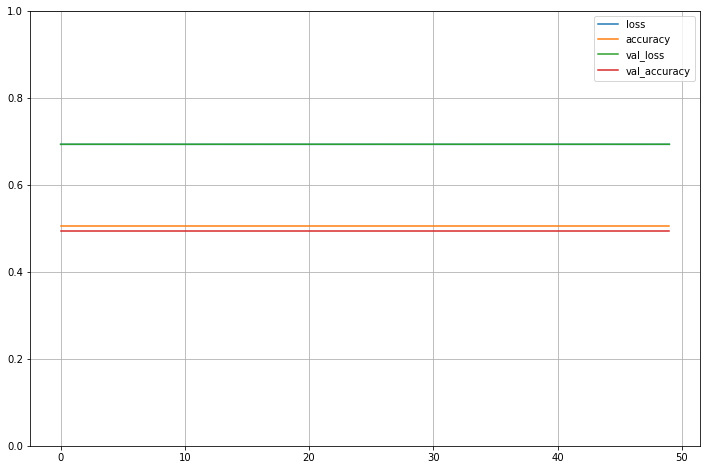

In [37]:
model_eval(history)

In [38]:
# A little better than guessing!
model_metrics(model)

Train Loss: 69.309%
Train Accuracy: 50.533%
Test Loss: 69.308%
Test Accuracy: 50.600%


## First CNN:
### Will be replaced with better version soon!

In [ ]:
# OLD MODEL, JUST LEAVING FOR REFERENCE
# Sequential model using convolutions
# Add dropout later
'''
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])
'''

In [56]:
# Sequential model using convolutions
# Add dropout later
# Using 350 x 350 images now, slightly reducing dropout, adding early stopping
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(350, 350,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(.4))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(.4))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 348, 348, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 174, 174, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 172, 172, 128)     73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 170, 170, 128)     147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 85, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 83, 83, 256)       295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 81, 81, 256)      

In [58]:
# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5)

In [63]:
# batch of 15, 50 ephochs
history = model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=15,
                    validation_data=(val_images, val_y),
                    callbacks = [early_stopping_cb])

Epoch 1/30
167/167 [==============================] - 420s 3s/step - loss: 0.6562 - acc: 0.6304 - val_loss: 0.6694 - val_acc: 0.5620
Epoch 2/30
167/167 [==============================] - 440s 3s/step - loss: 0.6523 - acc: 0.6332 - val_loss: 0.6964 - val_acc: 0.5140
Epoch 3/30
167/167 [==============================] - 443s 3s/step - loss: 0.6446 - acc: 0.6288 - val_loss: 0.6123 - val_acc: 0.6840
Epoch 4/30
167/167 [==============================] - 443s 3s/step - loss: 0.6337 - acc: 0.6508 - val_loss: 0.6292 - val_acc: 0.6620
Epoch 5/30
167/167 [==============================] - 440s 3s/step - loss: 0.6277 - acc: 0.6556 - val_loss: 0.6256 - val_acc: 0.6340
Epoch 6/30
167/167 [==============================] - 443s 3s/step - loss: 0.6249 - acc: 0.6736 - val_loss: 0.6289 - val_acc: 0.6640
Epoch 7/30
167/167 [==============================] - 440s 3s/step - loss: 0.6090 - acc: 0.6896 - val_loss: 0.6156 - val_acc: 0.7100
Epoch 8/30
167/167 [==============================] - 445s 3s/step - 

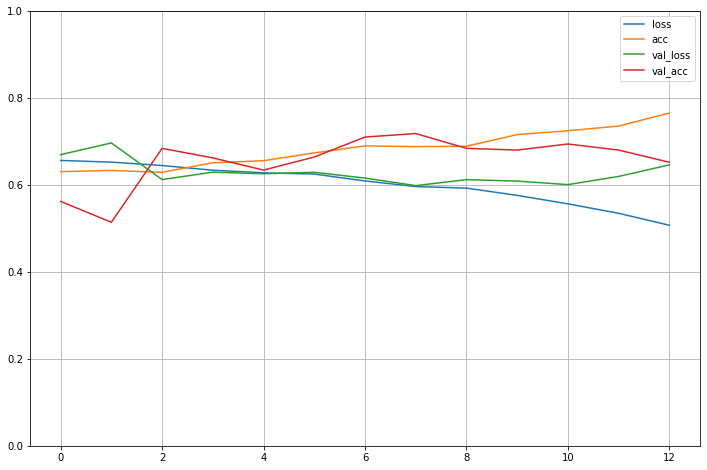

In [64]:
model_eval(history)

In [65]:
cnn_metrics(model)

Train Loss: 44.325%
Train Accuracy: 83.240%
Test Loss: 64.734%
Test Accuracy: 64.400%


In [66]:
model.save('cnn1.h5')

# END TEST ZONE:

## Baseline CNN:

## Deeper CNN:

In [43]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('cnn_model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10)

Use callbacks to save model and use early stopping.

Review Keras textbook for architecture examples.

## Neural Network Results:

### Accuracy and Precision:

### Confusion Matrix:

### Other Results:

# Future Work:

# Conclusion: